In [1]:
import numpy as np
import slepian
import matplotlib.pyplot as plt
from starry.kepler import Primary, Secondary, System
from scipy.optimize import minimize
import emcee
import corner
import sys

np.random.seed()

inferno = ["#EFE350FF","#F9B641FF","#F68F46FF","#DE7065FF","#B8627DFF","#90548BFF","#6B4596FF","#403891FF",
           "#13306DFF","#042333FF"]  
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = inferno)

In [2]:
def change_of_basis(L):
    """Slepian change of basis matrix.
    
    Parameters
    ----------
    L : int
        The bandlimit of the Slepian basis.
        
    Returns
    -------
    array
        An (L,L) numpy array such that t = np.dot(x,`array`). Where t is a vector in the 
        slepian basis and x is a vector in the spherical harmonic basis.
        
    """

    return np.array(slepian.slepianToHarmonic(L), dtype = float)

In [3]:
def make_system(star, planet):
    """Make a system given a star and a planet.
    
    Parameters
    ----------
    star : function
        A primary body from the starry.kepler module.
    planet : 
        A secondary body from the starry.kepler module.
        
    Returns
    -------
    function
        A Keplerian orbital system created using the given planet and star.
        
    """
    return System(star, planet)

def flux(body):
    """Compute the disk integrated intensity of either a star or a planet.
     
    Parameters
    ----------
    body : function
        Either a primary or secondary body from the starry.kepler module.
        
    Returns
    -------
    float
        The disk-integrated flux of the body in units of luminosity (average flux over the
        entire surface).
        
    """
    
    return body.flux()

def light_curve(body):
    """Retrieve the flux as a function of time emitted by either a star, planet or both 
    together in a system.
    
    Parameters
    ----------
    body : function
        A primary or secondary body from the starry.kepler module, or an orbital
        system consisting of both together.
        
    Returns
    -------
    array
        An array which contains the disk-integrated flux of the body after it has evolved
        in time. The times in question as specified when calling system.compute().
        
    Notes
    -----
    In all cases, the user must call system.compute() first.
    
    """
    
    return body.lightcurve

In [4]:
def get_par(planet):
    
    a = planet.a
    inc = planet.inc
    porb = planet.porb
    prot = planet.porb
    ecc = planet.ecc
    w = planet.w
    tref = planet.tref
    
    par = np.array([a, inc, porb, prot, ecc, w, tref])
    
    return par 

def get_map(planets, L):
    
    x = np.empty((len(planets), int((L+1)**2)))
    
    for i in range(len(planets)):
        x[i] = planets[i].y*planets[i].L
        
    return x

def set_par(par, wlp, planet):
    """Takes a parameter array and assigns them to a planet"""
    
    a, inc, porb, prot, ecc, w, tref = par
    d, r, noise = wlp
    
    # Set parameters.
    planet.a = a
    planet.inc = inc
    planet.porb = porb
    planet.prot = porb
    planet.ecc = ecc
    planet.w = w
    planet.tref = tref
    
    planet.r = r
    
    return

def set_map(x, planet, L):
    """Takes a spherical harmonic vector X and sets the starry map parameters."""
    
    # Pull out luminosity.
    planet.L = x[0]
    
    # Normalize the spherical harmonics.
    x = x/planet.L 
    
    # Set the other map coefficients.
    for l in range(1, L + 1):
        planet[l, :] = x[(l)**2 : (l + 1)**2]
  
    return

In [5]:
def presets(pln, wav, L):
    """Choose a planet."""
    
    if pln == 0:
        
        # Name
        name = "HD_189733b"
        
        # Orbital parameters
        a = 8.73  # Orbital semi-major axis in units of the stellar radius
        inc = 85.690  # Orbital inclination in degrees (90 is an edge-on orbit)
        porb = 2.21857567  # Orbital period in days
        prot = 2.21857567  # Rotation period in days (synchronous if prot = porb)
        ecc = 0  # Eccentricity
        w = 90   # Longitude of pericenter in degrees (meaningless for ecc = 0)
        tref = 2458334.990899  # Time of transit in Julian days
        par_ges = np.array([a, inc, porb, prot, ecc, w, tref])
        
        # Orbital parameter errors
        a_err = 0.15
        inc_err = 0.096
        porb_err = 0.00000015
        prot_err = 0.00000015
        ecc_err = 0.0039
        w_err = 0
        tref_err = 0.0007535
        par_err = np.array([a_err, inc_err, porb_err, prot_err, ecc_err, w_err, tref_err])
        
        # Wavelength dependent parameters and errors
        if wav is None:
            sys.exit("No wavelengths were specified.")
        else:
            wlp_ges = np.empty((len(wav), 3))
            wlp_err = np.empty((len(wav), 3))
            
            # [r: radius, d: eclipse depth, noise: flux error]
            for i in range(len(wav)):
                if (wav[i] >= 5.1 and wav[i] <= 6.3):
                    wlp_ges[i] = np.array([0.0031, 0.1503, 0.00010770072127003366])
                    wlp_err[i] = np.array([0.00034, 0.00385, 0.00010770072127003366/10])
                    
                elif (wav[i] >= 6.6 and wav[i] <= 9.0):
                    wlp_ges[i] = np.array([0.00344, 0.1600, 0.00010109069349505108])
                    wlp_err[i] = np.array([0.000036, 0.00385, 0.00010109069349505108/10])

                else:
                    sys.exit("There are not enough known orbital parameters for this \
                          wavelength.")
        
        # Time
        time = np.arange(1.01330250, 1.20527317, 1.1044444444444443e-04)
        time += -time[0]
        time += -time[len(time)-1]/2
        time += tref + porb/2
        
        return par_ges, par_err, wlp_ges, wlp_err, time, name
        
#     # WASP-33 b:
#     elif pln == 1:
        
#         # Name
#         name = "WASP_33b"
        
#         # Orbital parameters
#         a = 3.571 
#         inc = 86.63 
#         porb = 1.219870 
#         prot = 1.219870 
#         ecc = 0 
#         w = 90  
#         tref = 2452984.82964 
#         par_ges = np.array([a, inc, porb, prot, ecc, w, tref])
        
#         # Orbital parameter errors
#         a_err = 0.010
#         inc_err = 0.03
#         porb_err = 0.000001
#         prot_err = 0.000001
#         ecc_err = 0
#         w_err = 0
#         tref_err = 0.00030
#         par_err = np.array([a_err, inc_err, porb_err, prot_err, ecc_err, w_err, tref_err])

#         # Wavelength dependent parameters and errors
#         if wav is None:
#             sys.exit("No wavelengths were specified.")
#         else:
#             wlp_ges = np.empty((len(wav), 3))
#             wlp_err = np.empty((len(wav), 3))
            
#             # [r: radius, d: eclipse depth, noise: flux error]
#             for i in range(len(wav)):
#                 if (wav[i] >= 2.87 and wav[i] < 4,3):
#                     #wlp_ges[i] = np.array([0.0031, 0.1503, 3.0604450982799824e-05])
#                     #wlp_err[i] = np.array([0.00034, 0.00385, 3.0604450982799824e-05/10])
                    
#                 elif (wav[i] >= 4.3 and wav[i] <= 5.27):
#                     #wlp_ges[i] = np.array([0.00344, 0.1600, 5.53485283625356e-05])
#                     #wlp_err[i] = np.array([0.000036, 0.00385, 5.53485283625356e-05/10])

#                 else:
#                     sys.exit("There are not enough known orbital parameters for this \
#                           wavelength.")
        
        
#         # Errors:
#         d_err = 0.000173
#         r_err = 0.0002
        
#         noise_err = noise/10
        
#         # Time
#         time = np.arange(0.47020167, 0.74966833, 8.351851851851852e-04)
#         time += -time[0]
#         time += -time[len(time)-1]/2
#         time += tref + porb/2
        
#         return par_ges, par_err, wlp_ges, wlp_err, time, name
        
#     elif p == 2:
        
#         # Name
#         name = "KELT_9bb"
        
#         # Orbital parameters
#         a = 3.153 
#         inc = 86.79 
#         porb = 1.4811235 
#         prot = 1.4811235 
#         ecc = 0
#         w = 90  
#         tref = 2457095.68572 
#         par_ges = np.array([a, inc, porb, prot, ecc, w, tref])
        
#         # Orbital parameter errors
#         a_err = 0.011
#         inc_err = 0.25
#         porb_err = 0.0000011
#         prot_err = 0.0000011
#         ecc_err = 0
#         w_err = 0
#         tref_err = 0.00014
#         par_err = np.array([a_err, inc_err, porb_err, prot_err, ecc_err, w_err, tref_err])
        
#         # Wavelength dependent parameters and errors
#         if wav is None:
#             sys.exit("No wavelengths were specified.")
#         else:
#             wlp_ges = np.empty((len(wav), 3))
#             wlp_err = np.empty((len(wav), 3))
            
#             # [r: radius, d: eclipse depth, noise: flux error]
#             for i in range(len(wav)):
#                 if (wav[i] >= 2.87 and wav[i] < 4,3):
#                     #wlp_ges[i] = np.array([0.0031, 0.1503, 2.9891575807645507e-05])
#                     #wlp_err[i] = np.array([0.00034, 0.00385, 2.9891575807645507e-05/10])
                    
#                 elif (wav[i] >= 4.3 and wav[i] <= 5.27):
#                     #wlp_ges[i] = np.array([0.00344, 0.1600, 5.32351529698298e-05])
#                     #wlp_err[i] = np.array([0.000036, 0.00385, 5.32351529698298e-05/10])

#                 else:
#                     sys.exit("There are not enough known orbital parameters for this \
#                           wavelength.")
        
#         # Time
#         time = np.arange(0.55656842, 0.92455508, 8.351851851851852e-04)
#         time += -time[0]
#         time += -time[len(time)-1]/2
#         time += tref + porb/2
        
#         return par_ges, par_err, wlp_ges, wlp_err, time, name

In [6]:
def normal_par(par_ges, wlp_ges, par_err, wlp_err):
    """Creates random true parameters based on the published (guess) values and their standard deviations."""
    
    # Create the true values 
    par = np.random.randn(len(par_ges))*par_err + par_ges
    wlp = np.random.randn(len(wlp_ges), len(wlp_ges[0]))*wlp_err + wlp_ges
    
    # Make sure that eccentricity is positive.
    while par[4] < 0:
        par[4] = np.random.randn()*par_err[4] + par_ges[4] 
    
    return par, wlp

In [7]:
def initial_map(d, str_flx, L):
    """Creates a random map with luminosity set to one."""
    
    # Create random map array. We will set x00 using d.
    x = np.append([1], np.random.randn((L + 1)**2 - 1))
    
    # Make planet to test physicality.
    planet = Secondary(L)
    
    # Set coefficients.
    for l in range(1, L + 1):
        planet[l,:] = x[(l)**2:(l + 1)**2]
    
    # Ensure physicality
    while not planet.is_physical():
        x = np.append([1], np.random.randn((L + 1)**2 - 1))
        
        for l in range(1, L + 1):
            planet[l,:] = x[(l)**2:(l + 1)**2]
    
    x = np.repeat([x], len(d), axis = 0)
    d = np.transpose([d])
    str_flx = np.transpose([str_flx])
    pln_flx = planet.flux()
    
    
    return x*d*str_flx/pln_flx

In [8]:
def guess_map(x, map_err, d_ges, planets, str_flx, L):
    """Choose a guess based on the true map and the standard deviation."""
    
    # Re-normalize the map.
    x_ini = x/np.transpose([x[:,0]])
    
    # Make guesses (we will set x00 using d_ges).
    x_ges = np.append(np.zeros((len(d_ges), 1)), np.random.randn(len(d_ges), 
                      int(x_ini.size/len(d_ges)) - 1), axis = 1)
    x_ges = x_ges*map_err + x_ini
    
    # Set coefficients.
    for (x, planet) in zip(x_ges, planets):
        set_map(x, planet, L)
    
    # Get planetary flux
    pln_flx = np.array(list(map(flux, planets)), dtype = float)
    
    # Move to correct orientation.
    pln_flx = np.transpose([pln_flx])
    d_ges = np.transpose([d_ges])
    str_flx = np.transpose([str_flx])
    
    # Set x00_ges = L = Lp/Ls = d_ges*star.flux()/planet.flux().
    
    return x_ges*d_ges*str_flx/pln_flx

In [9]:
def fix_guess(par_ges, par_err, wlp_ges, wlp_err, map_ges, n):
    """Removes all fixed terms from the guess."""
    
    # Flatten everything so we can contruct a 1D array
    wlp_ges_flat = wlp_ges[:, 1:].flatten() # we never fit for d directly
    wlp_err_flat = wlp_err[:, 1:].flatten()
    map_ges_flat = map_ges.flatten() 
    
    ges = np.concatenate((par_ges[par_err != 0], wlp_ges_flat[wlp_err_flat != 0], map_ges_flat), axis = None)
    
    return ges

In [10]:
def ln_like(var, flx, par_ges, par_err, wlp_ges, wlp_err, arg, M):
    """Log likelihood."""
    
    # Unpack the arguments:
    time, systems, planets, str_flx, a, b, c, n, L = arg
    
    # Split up the variables.
    par_var = var[ : a]
    wlp_var = var[a : a + b]
    map_var = var[a + b : ]
    
    """Check Priors."""
    
    # All parameters should be non-negative
    if np.any(par_var < 0):
        return -np.inf
    
    # All wl parameters should be positive:
    if np.any(wlp_var <= 0):
        return -np.inf
    
    # Reshape variable map and change to harmonic basis
    map_var = np.reshape(map_var, (n, int(c/n)))
    x_var = np.dot(map_var, np.transpose(M))

    # x_{0,0} > 0 so that luminosity is positive.
    if np.any(x_var[:, 0] <= 0):
        return -np.inf
    
    """Fill in missing orbital parameters."""
    
    # Set coefficients (needed to set d)
    for (x, planet) in zip(x_var, planets):
        set_map(x, planet, L)
    
    # Add in missing par.
    par_var = np.insert(par_var, np.where(par_err == 0)[0] 
                        - np.arange(len(par_err[par_err == 0])), 
                        par_ges[par_err == 0])
    
    d_ges = wlp_ges[:, 0]
    d_err = wlp_err[:, 0]
    wlp_ges_flat = wlp_ges[:, 1:].flatten()
    wlp_err_flat = wlp_err[:, 1:].flatten()
    
    # Add in fixed wlp terms (except for d).
    wlp_var = np.insert(wlp_var, np.where(wlp_err_flat == 0)[0] 
                        - np.arange(len(wlp_err_flat[wlp_err_flat == 0])), 
                        wlp_ges_flat[wlp_err_flat == 0])

    # Compute non-fixed d's
    pln_flx = np.array(list(map(flux, planets[d_err != 0])), dtype = float)
    d_var = x_var[:,0][d_err != 0]*pln_flx/str_flx[d_err != 0]
    

    # Get fixed d's
    d_var = np.insert(d_var, np.where(d_err == 0)[0] - np.arange(len(d_err[d_err == 0])),
                        d_ges[d_err == 0])
    
    # Add in d's.
    wlp_var = np.insert(wlp_var, np.arange(n)*2, d_var)
    
    """Gaussian Priors."""
    
    # Gaussian par priors
    gpp = np.divide(par_var - par_ges, par_err, out = np.zeros_like(par_var), where = par_err != 0)
    l = -0.5*np.sum(gpp**2)
    
    # Gaussian wlp priors
    gwp = np.divide(wlp_var - wlp_ges.flatten(), wlp_err.flatten(), out = np.zeros_like(wlp_var), where = wlp_err.flatten() != 0)
    l += -0.5*np.sum(gwp**2)
    
    """Compute Likelihood."""
    
    wlp_var = np.reshape(wlp_var, (n, 3))
    
    # Set parameters and compute flux
    for (wlp, system, planet) in zip(wlp_var, systems, planets):
        set_par(par_var, wlp, planet)
        system.compute(time)
    
    flx_var = np.array(list(map(light_curve, planets)), dtype = float)
    flx_err = np.transpose([wlp_var[:,2]])
    
    # Compute the ln likelihood.
    like = np.sum(((flx - flx_var)/flx_err)**2 + 2*np.log(flx_err))
    l += -0.5*like
    
    return l

In [11]:
def ml_solution(flx, par_ges, par_err, wlp_ges, wlp_err, map_ges, arg, M):
    """Maximum likelihood solution."""
    
    # Unpack the constants:
    time, systems, planets, str_flx, a, b, c, n, L = arg
    
    # Assemble guess array and throw away parameters that are held fixed so we don't fit for them
    ges = fix_guess(par_ges, par_err, wlp_ges, wlp_err, map_ges, n)
    
    # Define negative log likelihood
    neg_ln_like = lambda *inputs: -ln_like(*inputs)
    
    # Find the numerical optimum of the likelihood function
    soln = minimize(neg_ln_like, ges, args = (flx, par_ges, par_err, wlp_ges, wlp_err, arg, M), method = 'Nelder-Mead', options = {'maxiter': len(ges)*500})
    mls = soln.x
    
    print("Max likelihood convergence:", soln.success)
    print("Number of iterations:", soln.nit)
    
    # Split up the variables.
    par_mls = mls[ : a]
    wlp_mls = mls[a : a + b]
    map_mls = mls[a + b : ]

    # Reshape map and change to harmonic basis.
    map_mls = np.reshape(map_mls, (n, int(c/n)))
    x_mls = np.dot(map_mls, np.transpose(M))
    
    # Set coefficients (needed to set d)
    for (x, planet) in zip(x_mls, planets):
        set_map(x, planet, L)
    
    # Add in missing par.
    par_mls = np.insert(par_mls, np.where(par_err == 0)[0] - np.arange(len(par_err[par_err == 0])), par_ges[par_err == 0])
    
    d_ges = wlp_ges[:, 0]
    d_err = wlp_err[:, 0]
    wlp_ges_flat = wlp_ges[:, 1:].flatten()
    wlp_err_flat = wlp_err[:, 1:].flatten()
    
    # Add in fixed wlp terms (except for d).
    wlp_mls = np.insert(wlp_mls, np.where(wlp_err_flat == 0)[0] - np.arange(len(wlp_err_flat[wlp_err_flat == 0])), 
                        wlp_ges_flat[wlp_err_flat == 0])

    # Compute non-fixed d's
    pln_flx = np.array(list(map(flux, planets[d_err != 0])), dtype = float)
    d_mls_com = x_mls[:,0][d_err != 0]*pln_flx/str_flx[d_err != 0]
    

    # Add fixed d's
    d_mls = np.insert(d_mls_com, np.where(d_err == 0)[0] - np.arange(len(d_err[d_err == 0])),
                        d_ges[d_err == 0])
    
    # Add in d's.
    wlp_mls = np.insert(wlp_mls, np.arange(n)*2, d_mls)
    
    wlp_mls = np.reshape(wlp_mls, (n, 3))
    
    # Set parameters and compute flux
    for (wlp, system, planet) in zip(wlp_mls, systems, planets):
        set_par(par_mls, wlp, planet)
        system.compute(time)
        
    flx_mls = np.array(list(map(light_curve, planets)), dtype = float)

    mls = np.concatenate((par_mls[par_err != 0], wlp_mls.flatten()[wlp_err.flatten() != 0],
                         map_mls), axis = None)

    return mls, flx_mls 

In [12]:
def set_walkers(mls, par_ges, par_err, wlp_ges, wlp_err, arg, M, walkers):
    """Initialization in a ball around the max likelihood solution."""
    
    # Unpack the arguments:
    time, systems, planets, str_flx, a, b, c, n, L = arg
    
    # Split up the variables.
    par_mls = mls[ : a]
    wlp_mls = mls[a : len(mls) - c] #may contain d terms
    map_mls = mls[len(mls) - c : ]

    # Get inital position of parameters.
    par_ini = np.random.randn(walkers, a)*par_err[par_err != 0] + par_mls
    
    for i in range(walkers):
        while np.any(par_ini[i] < 0):
            par_ini[i] = np.random.randn(a)*par_err[par_err != 0] + par_mls
    
    # Get initial wavelength dependent parameters and seperate d
    d_ges = wlp_ges[:, 0]
    d_err = wlp_err[:, 0]
    wlp_ges_flat = wlp_ges[:, 1:].flatten()
    wlp_err_flat = wlp_err[:, 1:].flatten()
    
    
    # Indices with computed d
    index = np.array([], dtype = int)
    fixed = 0
    for i in range(n):
        if wlp_err[i][0] != 0:
            index = np.append(index, 3*i - fixed)
        fixed += 3 - len(np.nonzero(wlp_err[i])[0])
     
    d_mls = wlp_mls[index]
    wlp_mls = np.delete(wlp_mls, index)
    
    wlp_ini = np.random.randn(walkers, b)*wlp_err_flat[wlp_err_flat != 0] + wlp_mls
    
    for i in range(walkers):
        while np.any(wlp_ini[i] <= 0):
            wlp_ini[i] = np.random.randn(b)*wlp_err_flat[wlp_err_flat != 0] + wlp_mls 
    
    # Get initial map coefficients.
    
    # Reshape and change to harmonic basis.
    map_mls = np.reshape(map_mls, (n, int(c/n)))
    x_mls = np.dot(map_mls, np.transpose(M))
    
    # Add missing eclipse depths
    d_mls = np.insert(d_mls, np.where(d_err == 0)[0] - np.arange(len(d_err[d_err == 0])), d_ges[d_err == 0])
    
    # Generate some random eclipse depths
    d_ini = np.random.randn(walkers, n)*d_err + d_mls 
    
    for i in range(walkers):
        while np.any(d_ini[i] <= 0):
            d_ini[i] = np.random.randn(n)*d_err + d_mls
    
    # Initialize the maps.
    x_ini = np.broadcast_to(x_mls, (walkers, n , int(c/n)))
    
    initialize = lambda x, d: guess_map(x, 1/100, d, planets, str_flx, L)
    x_ini = np.array(list(map(initialize, x_ini, d_ini)))
    
    for i in range(walkers):
        while np.any(x_ini[i,:,0] <= 0):
            x_ini[i] = guess_map(x_mls, 1/100, d_ini[i], planets, str_flx, L)
    
    # Change back to original basis.
    map_ini = np.empty_like(x_ini)
    
    for i in range(walkers):
        map_ini[i] = np.dot(x_ini[i], M)
    
    map_ini = np.reshape(map_ini, (walkers, c))
    
    # Combine.
    ini = np.concatenate((par_ini, wlp_ini, map_ini), axis = 1)
    
    return ini

In [13]:
def mc_solution(flx, mls, par_ges, par_err, wlp_ges, wlp_err, arg, M, walkers, steps):
    
    # Unpack the arguments:
    time, systems, planets, str_flx, a, b, c, n, L = arg
    
    # Initialize around the max likelihood solution
    ini = set_walkers(mls, par_ges, par_err, wlp_ges, wlp_err, arg, M, walkers)
    
    # Run an MCMC chain
    sampler = emcee.EnsembleSampler(walkers, a + b + c, ln_like, args = (flx, par_ges, 
                                                                         par_err, wlp_ges,
                                                                         wlp_err, arg, M))
    sampler.run_mcmc(ini, steps, progress = True, skip_initial_state_check = True)
    smp = sampler.get_chain(discard = 1000, flat = True)
    chn = sampler.get_chain()
    
    # Get the mc solution and error
    mcp = np.percentile(np.transpose(smp), [16, 50, 84], axis = 1)
    mcs = mcp[1]
    mce = np.mean(np.diff(np.transpose(mcp)), axis = 1)

    # Split up the variables.
    par_mcs = mcs[ : a]
    wlp_mcs = mcs[a : a + b]
    map_mcs = mcs[a + b : ]

    # Reshape map and change to harmonic basis.
    map_mcs = np.reshape(map_mcs, (n, int(c/n)))
    x_mcs = np.dot(map_mcs, np.transpose(M))
    
    # Set coefficients (needed to set d)
    for (x, planet) in zip(x_mcs, planets):
        set_map(x, planet, L)
    
    # Add in missing par.
    par_mcs = np.insert(par_mcs, np.where(par_err == 0)[0] 
                        - np.arange(len(par_err[par_err == 0])), par_ges[par_err == 0])
    
    
    d_ges = wlp_ges[:, 0]
    d_err = wlp_err[:, 0]
    wlp_ges_flat = wlp_ges[:, 1:].flatten()
    wlp_err_flat = wlp_err[:, 1:].flatten()
    
    # Add in fixed wlp terms (except for d).
    wlp_mcs = np.insert(wlp_mcs, np.where(wlp_err_flat == 0)[0] 
                        - np.arange(len(wlp_err_flat[wlp_err_flat == 0])), 
                        wlp_ges_flat[wlp_err_flat == 0])

    
    # Compute non-fixed d's
    pln_flx = np.array(list(map(flux, planets[d_err != 0])), dtype = float)
    d_mcs_com = x_mcs[:,0][d_err != 0]*pln_flx/str_flx[d_err != 0]
    

    # Get fixed d's
    d_mcs = np.insert(d_mcs_com, np.where(d_err == 0)[0] - np.arange(len(d_err[d_err == 0])),
                        d_ges[d_err == 0])
    
    # Add in d's.
    wlp_mcs = np.insert(wlp_mcs, np.arange(n)*2, d_mcs)
    
    wlp_mcs = np.reshape(wlp_mcs, (n, 3))
    
    # Set parameters and compute flux
    for (wlp, system, planet) in zip(wlp_mcs, systems, planets):
        set_par(par_mcs, wlp, planet)
        system.compute(time)
    
    flx_mcs = np.array(list(map(light_curve, planets)), dtype = float)

    mcs = np.concatenate((par_mcs[par_err != 0], wlp_mcs.flatten()[wlp_err.flatten() != 0],
                         map_mcs), axis = None)
    
    if len(d_mcs_com) >= 1:
        
        par_mce = mce[ : a]
        wlp_mce = mce[a : a + b]
        map_mce = mce[a + b : ]
        
        # Find the stardard deviation of d
        smp_len = 1000
        d_smp = np.empty((smp_len, len(d_mcs_com)))

        ind = np.random.randint(0, len(smp), smp_len)

        for i in range(smp_len):

            map_smp = smp[ind[i]][a + b : ]
            map_smp = np.reshape(map_smp, (n, int(c/n)))
            x_smp = np.dot(map_smp, np.transpose(M))

            for (x, planet) in zip(x_smp[d_err != 0], planets[d_err != 0]):
                set_map(x, planet, L)

            pln_flx_smp = np.array(list(map(flux, planets[d_err != 0])), dtype = float)

            d_smp[i] = x_smp[:,0][d_err != 0]*pln_flx_smp/str_flx[d_err != 0]

        d_mcp = np.percentile(np.transpose(d_smp), [16, 50, 84], axis = 1)
        d_mce = np.mean(np.diff(np.transpose(d_mcp)), axis = 1)
        
        # Add placeholder terms to make it easier to add d_mce to the right places
        d_mce = np.insert(d_mce, np.where(d_err == 0)[0] - np.arange(len(d_err[d_err == 0])),
                        d_ges[d_err == 0])
    
        wlp_mce = np.insert(wlp_mce, np.where(wlp_err_flat == 0)[0] 
                        - np.arange(len(wlp_err_flat[wlp_err_flat == 0])), 
                        wlp_ges_flat[wlp_err_flat == 0])
        
        wlp_mce = np.insert(wlp_mce, np.arange(n)*2, d_mce)
        
        # We take out the placeholders here
        mce = np.concatenate((par_mce, wlp_mce[wlp_err.flatten() != 0], map_mce),
                             axis = None)
    
    return mcs, mce, flx_mcs, chn

In [14]:
def fit(
        flx, time, M,  par_ges=None, par_err=np.array([0.,0.,0.,0.,0.,0.,0.]), 
        wlp_ges=np.array([[0.001, 0.1, 0.01]]), wlp_err=np.array([[0.,0.,0.]]), 
        map_ges=None, stars=None, planets=None):
    
    # Get the bandlimit L.
    L = int(np.sqrt(len(M)))-1
        
    # Get the number of wavelengths n.
    n = len(planets) #number of wavelengths
   
    # Check the inputs
    if (np.shape(par_err) != (7,)):
        print("par_err must be an (7,) array")
    
    if (n >= 1) and (np.shape(wlp_ges) == (1,3)):
        wlp_ges = np.repeat(wlp_ges, n, axis = 0)
    elif (np.shape(wlp_ges) != (n,3)):
        print("wlp must be a (1,3) or an (" + str(n) + ",3) array.")
        return
        
    if (n > 1) and (np.shape(wlp_err) == (1,3)):
        wlp_err = np.repeat(wlp_err, n, axis = 0)
    elif (np.shape(wlp_err) != (n,3)):
        print("wlp_err must be a (1,3) or an (" + str(n) + ",3) array.")
        return
    
    if stars is None:
        stars = np.array([Primary() for star in range(n)])
    
    if planets is None:
        planets = np.array([Secondary(L) for planet in range(n)])
    
    # Get the guess orbital parameters and map coefficents  
    if par_ges is None:
        par_ges = get_par(planets[0])
        
    if map_ges is None:
        x_ges = get_map(planets, L)
        map_ges = np.dot(x_ges, C)
        
    # Get the star flux
    str_flx = np.array(list(map(flux, stars)), dtype = float)
    
    # Make systems
    systems = np.array(list(map(make_system, stars, planets)))
    
    # a is the number of fitted parameters
    a = len(par_err[par_err != 0])
    
    # b is the total number of fitted wavelength dependent parameters.
    b = len(wlp_err[:,1:].flatten()[wlp_err[:,1:].flatten() != 0])
    
    # c is the number of fitted map coefficients.
    c = n*(L + 1)**2
    
    # Define arguments.
    arg = time, systems, planets, str_flx, a, b, c, n, L
    
    # Find the max likelihood solution and flux.
    mls, flx_mls = ml_solution(flx, par_ges, par_err, wlp_ges, wlp_err, map_ges, arg, M)
    
    # Run an MCMC chain.
    walkers = 2*(a + b + c)
    steps = 5000
    mcs, mce, flx_mcs, chn = mc_solution(flx, mls, par_ges, par_err, wlp_ges, wlp_err, arg, M, walkers, steps)
    
    return mls, flx_mls, mcs, flx_mcs, mce, chn

In [15]:
def make_labels(par_err, wlp_err, wav, L):
    
    # Parameter labels list.
    par = np.array(["a", "inc", "porb", "prot", "ecc", "w", "tref"])
    par = par[par_err != 0]
    
    # Wavelength dependent parameters (except for d which is never plotted)
    wlp_err_flat = wlp_err[:, 1:].flatten()
    
    wlp = np.empty((len(wav), 2), dtype = object)
    
    for i in range(len(wlp)):
        wlp[i][0] = r"$r^{" + str(wav[i]) + "}$"
        wlp[i][1] = r"$\sigma^{" + str(wav[i]) + "}$"
    
    wlp = np.array(wlp).flatten()
    wlp = wlp[wlp_err_flat != 0]
    
    # Map coefficient labels
    t = np.empty((len(wav), (L + 1)**2), dtype = object)
    x = np.empty((len(wav), (L + 1)**2), dtype = object)
    
    for i in range(len(wav)):
    
        for n in range((L+1)**2):
            t[i][n] = r"$t^{" + str(wav[i]) + "}_{" + str(n+1) + "}$"
        
        k = 0
        for l in range(L+1):
            for m in range(-l,l+1):
                x[i][k] = r"$x^{" + str(wav[i]) + "}_{" + str(l) + "," + str(m) + "}$"
                k += 1
                
    t = np.array(t).flatten()
    x = np.array(x).flatten()
    
    
    labels_s = np.concatenate(("Slepian", par, wlp, t), axis = None)
    labels_s = np.array(labels_s, dtype = str)
    
    labels_h = np.concatenate(("Harmonic", par, wlp, x), axis = None)
    labels_h = np.array(labels_h, dtype = str)
    
    return np.concatenate(([labels_s], [labels_s]), axis = 0)

In [16]:
def make_plots(
        Flux, Sol, Chain, par_tru, par_err, wlp_tru, wlp_err, wav, time, systems,
        planets, C, I):
    """Construct plots."""
    
    # Unpack arguments:
    L = int(np.sqrt(len(I)))-1
    
    n = len(planets)
    
    a = len(par_err[par_err != 0])
    b = len(wlp_err[:,1:].flatten()[wlp_err[:,1:].flatten() != 0])
    c = n*(L + 1)**2
    
    Labels = make_labels(par_err, wlp_err, wav, L)
    
    Matrices = np.concatenate(([C],[I]), axis = 0)
    
    porb = par_tru[2]
    tref = par_tru[6]
    
    tests, steps, walkers, variables = np.shape(Chain)
    
    
    """MCMC chains plot."""
    
    for (chn, labels) in zip(Chain, Labels):
    
        fig, axes = plt.subplots(variables, figsize = (15, 10), sharex = True)
        for i in range(variables):
            ax = axes[i]
            ax.plot(chn[: , : , i], alpha = 0.3, lw = 1)
            ax.set_xlim(0, steps)
            ax.set_ylabel(labels[i+1], fontsize = 10)
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("Number of Steps", fontsize = 14)
        plt.show()
        #name = "plot_" + str(p) + "_" + str(i) + "_0_" + labels[0].lower()
        #plt.savefig(name, dpi = 150)
        plt.clf()

      
    """MCMC sample plot."""
    
    Chain = np.reshape(Chain, (tests, steps*walkers, variables))
    Chain = Chain[: , walkers*1000 : , :]  
    
    len_smp = 500
    ind = np.random.randint(0, len(Chain[0]), len_smp)

    
    d_tru = wlp_tru[:, 0]
    d_err = wlp_err[:, 0]
    wlp_tru_flat = wlp_tru[:, 1:].flatten()
    wlp_err_flat = wlp_err[:, 1:].flatten()
    
    

    for (chn, M) in zip(Chain, Matrices):
        
        flx_smp = np.empty((len_smp, n, len(time)))
        
        for i in range(len_smp):
                
                # Split up the variables.
                par_smp = chn[ind[i]][ : a]
                wlp_smp = chn[ind[i]][a : a + b]
                map_smp = chn[ind[i]][a + b : ]
                
                # Add in missing par.
                par_smp = np.insert(par_smp, np.where(par_err == 0)[0] 
                                    - np.arange(len(par_err[par_err == 0])),
                                    par_tru[par_err == 0])
    
                # Add in missing wlp.
                wlp_smp = np.insert(wlp_smp, np.where(wlp_err_flat == 0)[0] 
                                    - np.arange(len(wlp_err_flat[wlp_err_flat == 0])),
                                    wlp_tru_flat[wlp_err_flat == 0])

                # Add in d's. (they don't actually matter for making lightcurves)
                wlp_smp = np.insert(wlp_smp, np.arange(n)*2, d_tru)

                # Reshape
                wlp_smp = np.reshape(wlp_smp, (n, 3))
                
                map_smp = np.reshape(map_smp, (n, int(c/n)))
                x_smp = np.dot(map_smp, np.transpose(M))
    
                # Set coefficients and parameters and compute flux.
                for (wlp, x, system, planet) in zip(wlp_smp, x_smp, systems, planets):
                    set_par(par_smp, wlp, planet)
                    set_map(x, planet, L)
                    system.compute(time)
    
                flx_smp[i] = np.array(list(map(light_curve, planets)), dtype = float)
        
        plt.figure(figsize = (15,10))
        
        fig, axes = plt.subplots(n, 1, figsize = (15, 10))
        for i in range(n):
            ax = axes[i]
            ax.plot((time - (tref + porb/2))*60*24, Flux[0][i], color = inferno[0], marker = '.', ls = 'None',
                    ms = 1.5, label = 'Flux with noise')
            
            for j in range(len_smp):
                ax.plot((time - (tref + porb/2))*60*24, flx_smp[j][i], color = inferno[1], marker = 'None', 
                        ls = '-', lw = 1, alpha = 0.1)
                
            ax.plot((time - (tref + porb/2))*60*24, Flux[1][i], color = inferno[6], marker = 'None', ls = '-', 
                lw = 1, label = 'True Flux')
            
            ax.legend(loc = 3, fontsize = 14)
            
            if i != 0:
                ax.set_xticks([])
                
        axn = plt.subplot(n, 1, n)
        for i in range(n):
            axn.annotate("$\lambda$ = " + str(wav[i]) + "μm", xy = (825,75 + 275*i), xycoords = 'figure points', fontsize = 14)
                

        plt.subplots_adjust(hspace = 0)
        fig.supylabel("Planetary Flux", x = 0.05, y = 0.5, fontsize = 16)
        fig.supxlabel("Time from Eclipse (minutes)", x = 0.5, y = 0.05, fontsize = 16)
        plt.show()
        plt.clf()    
        
        
    """Results plot.""" 
 
    fig, axes = plt.subplots(n, 1, figsize = (15, 10))
    for i in range(n):
        ax = axes[i]
        ax.plot((time - (tref + porb/2))*60*24, Flux[0][i], color = inferno[0], marker = '.', ls = 'None',
                ms = 1.5, label = 'Flux with noise')
        ax.plot((time - (tref + porb/2))*60*24, Flux[1][i], color = inferno[2], marker = 'None', ls = '-', 
                lw = 1, label = 'True Flux')
        ax.plot((time - (tref + porb/2))*60*24, Flux[2][i], color = inferno[4], marker = 'None', ls = '-', 
                lw = 1, label = 'Guess Flux')
        ax.plot((time - (tref + porb/2))*60*24, Flux[3][i], color = inferno[5], marker = 'None', ls = '-', 
                lw = 1, label = 'Slepian Max Likelihood Flux')
        ax.plot((time - (tref + porb/2))*60*24, Flux[4][i], color = inferno[5], marker = 'None', ls = ':', 
                lw = 1, label = 'Slepian MCMC Flux')
        ax.plot((time - (tref + porb/2))*60*24, Flux[5][i], color = inferno[9], marker = 'None', ls = '-', 
                lw = 1, label = 'Harmonic Max Likelihood Flux')
        ax.plot((time - (tref + porb/2))*60*24, Flux[6][i], color = inferno[9], marker = 'None', ls = ':', 
                lw = 1, label = 'Harmonic MCMC Flux')
        ax.legend(loc = 3, fontsize = 14)
        if i != (n-1):
                ax.set_xticks([])
                
    axn = plt.subplot(n, 1, n)
    for i in range(n):
        axn.annotate("$\lambda$ = " + str(wav[i]) + "μm", xy = (825,75 + 275*i), xycoords = 'figure points', fontsize = 14)
    
    plt.subplots_adjust(hspace = 0)
    fig.supylabel("Planetary Flux", x = 0.05, y = 0.5, fontsize = 16)
    fig.supxlabel("Time from Eclipse (minutes)", x = 0.5, y = 0.05, fontsize = 16)
    plt.show()
    plt.clf()
            
            
    """Corner plot.""" 
    
    #Unfortunately, running this with so many variables always crashes my computer.
    
#     for (sol, chn, labels) in zip(Sol, Chain, Labels):
        
#         # Indices with computed d
#         index = np.array([], dtype = int)
#         fixed = 0
#         for i in range(n):
#             if wlp_err[i][0] != 0:
#                 index = np.append(index, 3*i - fixed)
#             fixed += 3 - len(np.nonzero(wlp_err[i])[0])

#         tru = np.delete(sol[0], a + index)
    
#         fig = corner.corner(chn, labels = labels[1:], bins = 50, truths = tru);

#         for ax in fig.axes:
#             ax.xaxis.label.set_fontsize(20)
#             ax.yaxis.label.set_fontsize(20)
            
#         #name = "plot_" + str(p) + "_" + str(i) + "_2_" + labels[0].lower()
#         #plt.savefig(name, dpi = 150)
#         plt.show()
#         plt.clf()
    
    plt.close('all')
    
    return

In [17]:
def comparison_test(pln, C, star=Primary(), wav=None):

    # Choose a bandlimit L.
    L = int(np.sqrt(len(C))) - 1
    
    # Create a suitable identity Matrix.
    I = np.identity((L + 1)**2)
    
    # Create an array of planets
    par_ges, par_err, wlp_ges, wlp_err, time, name = presets(pln, wav, L)
    
    # Get the number of wavelengths.
    if wav is None:
        n = 1
    else:
        n = len(wav)
    
    # Instantiate stars, planets and a systems.
    stars = np.array([Primary() for star in range(n)])
    planets = np.array([Secondary(L) for planet in range(len(wav))])
    systems = np.array(list(map(make_system, stars, planets)))
    
    # Define true parameters.
    par_tru, wlp_tru = normal_par(par_ges, wlp_ges, par_err, wlp_err)
    
    # Get the star flux
    str_flx = np.array(list(map(flux, stars)), dtype = float)
    
    # Choose a semi-random planetary maps.
    x_tru = initial_map(wlp_tru[:,0], str_flx, L)
    
    # Get true map in Slepian basis.
    t_tru = np.dot(x_tru, C)
    
    # Set true parameters and coefficients and get flux.
    for (x, wlp, system, planet) in zip(x_tru, wlp_tru, systems, planets):
        set_par(par_tru, wlp, planet)
        set_map(x, planet, L)
        system.compute(time)
    
    flx_tru = np.array(list(map(light_curve, planets)), dtype = float)
    
    # Create noised flux
    flx = np.transpose([wlp_tru[:,2]])*np.random.randn(len(flx_tru), len(time)) + flx_tru
    
    # Define truth arrays for comparison purposes
    tru_slp = np.concatenate((par_tru[par_err != 0], wlp_tru.flatten()[wlp_err.flatten() != 0], t_tru),
                             axis = None)
    tru_har = np.concatenate((par_tru[par_err != 0], wlp_tru.flatten()[wlp_err.flatten() != 0], x_tru),
                             axis = None)
    
    # Set the standard deviation of the guess map coefficients in units of L.
    map_err = 1/10
    
    # Make a guess map.
    x_ges = guess_map(x_tru, map_err, wlp_ges[:,0], planets, str_flx, L)
    
    # Get guess map in Slepian basis.
    t_ges = np.dot(x_ges, C)
    
    # Set guess parameters and coefficients and compute flux..
    for (wlp, x, system, planet) in zip(wlp_ges, x_ges, systems, planets):
        set_par(par_ges, wlp, planet)
        set_map(x, planet, L)
        system.compute(time)
    
    flx_ges = np.array(list(map(light_curve, planets)), dtype = float)
    
    # Fit light curve (planets are set to guess)
    mls_slp, flx_mls_slp, mcs_slp, flx_mcs_slp, mce_slp, chn_slp \
    = fit(flx, time, C, par_ges, par_err, wlp_ges, wlp_err, t_ges, stars, planets)
    
    mls_har, flx_mls_har, mcs_har, flx_mcs_har, mce_har, chn_har \
    = fit(flx, time, I, par_ges, par_err, wlp_ges, wlp_err, x_ges, stars, planets)
    
    # Results
    Flux = np.concatenate(([flx], [flx_tru], [flx_ges], [flx_mls_slp], [flx_mls_har], [flx_mcs_slp], [flx_mcs_har]), axis = 0)
    
    sol_slp = np.concatenate(([tru_slp], [mls_slp], [mcs_slp], [mce_slp]), axis = 0)
    sol_har = np.concatenate(([tru_har], [mls_har], [mcs_har], [mce_har]), axis = 0)
    
    Sol = np.concatenate(([sol_slp], [sol_har]), axis = 0)
    
    Chain = np.concatenate(([chn_slp], [chn_har]), axis = 0)
    
    # Plot
    make_plots(Flux, Sol, Chain, par_tru, par_err, wlp_tru, wlp_err, wav, time, systems,
               planets, C, I)
    
    return Flux, Sol

  0%|          | 0/5000 [00:00<?, ?it/s]

Max likelihood convergence: True
Number of iterations: 3515


  0%|          | 0/5000 [00:00<?, ?it/s]

Max likelihood convergence: True
Number of iterations: 6350


100%|██████████| 5000/5000 [08:30<00:00,  9.80it/s]


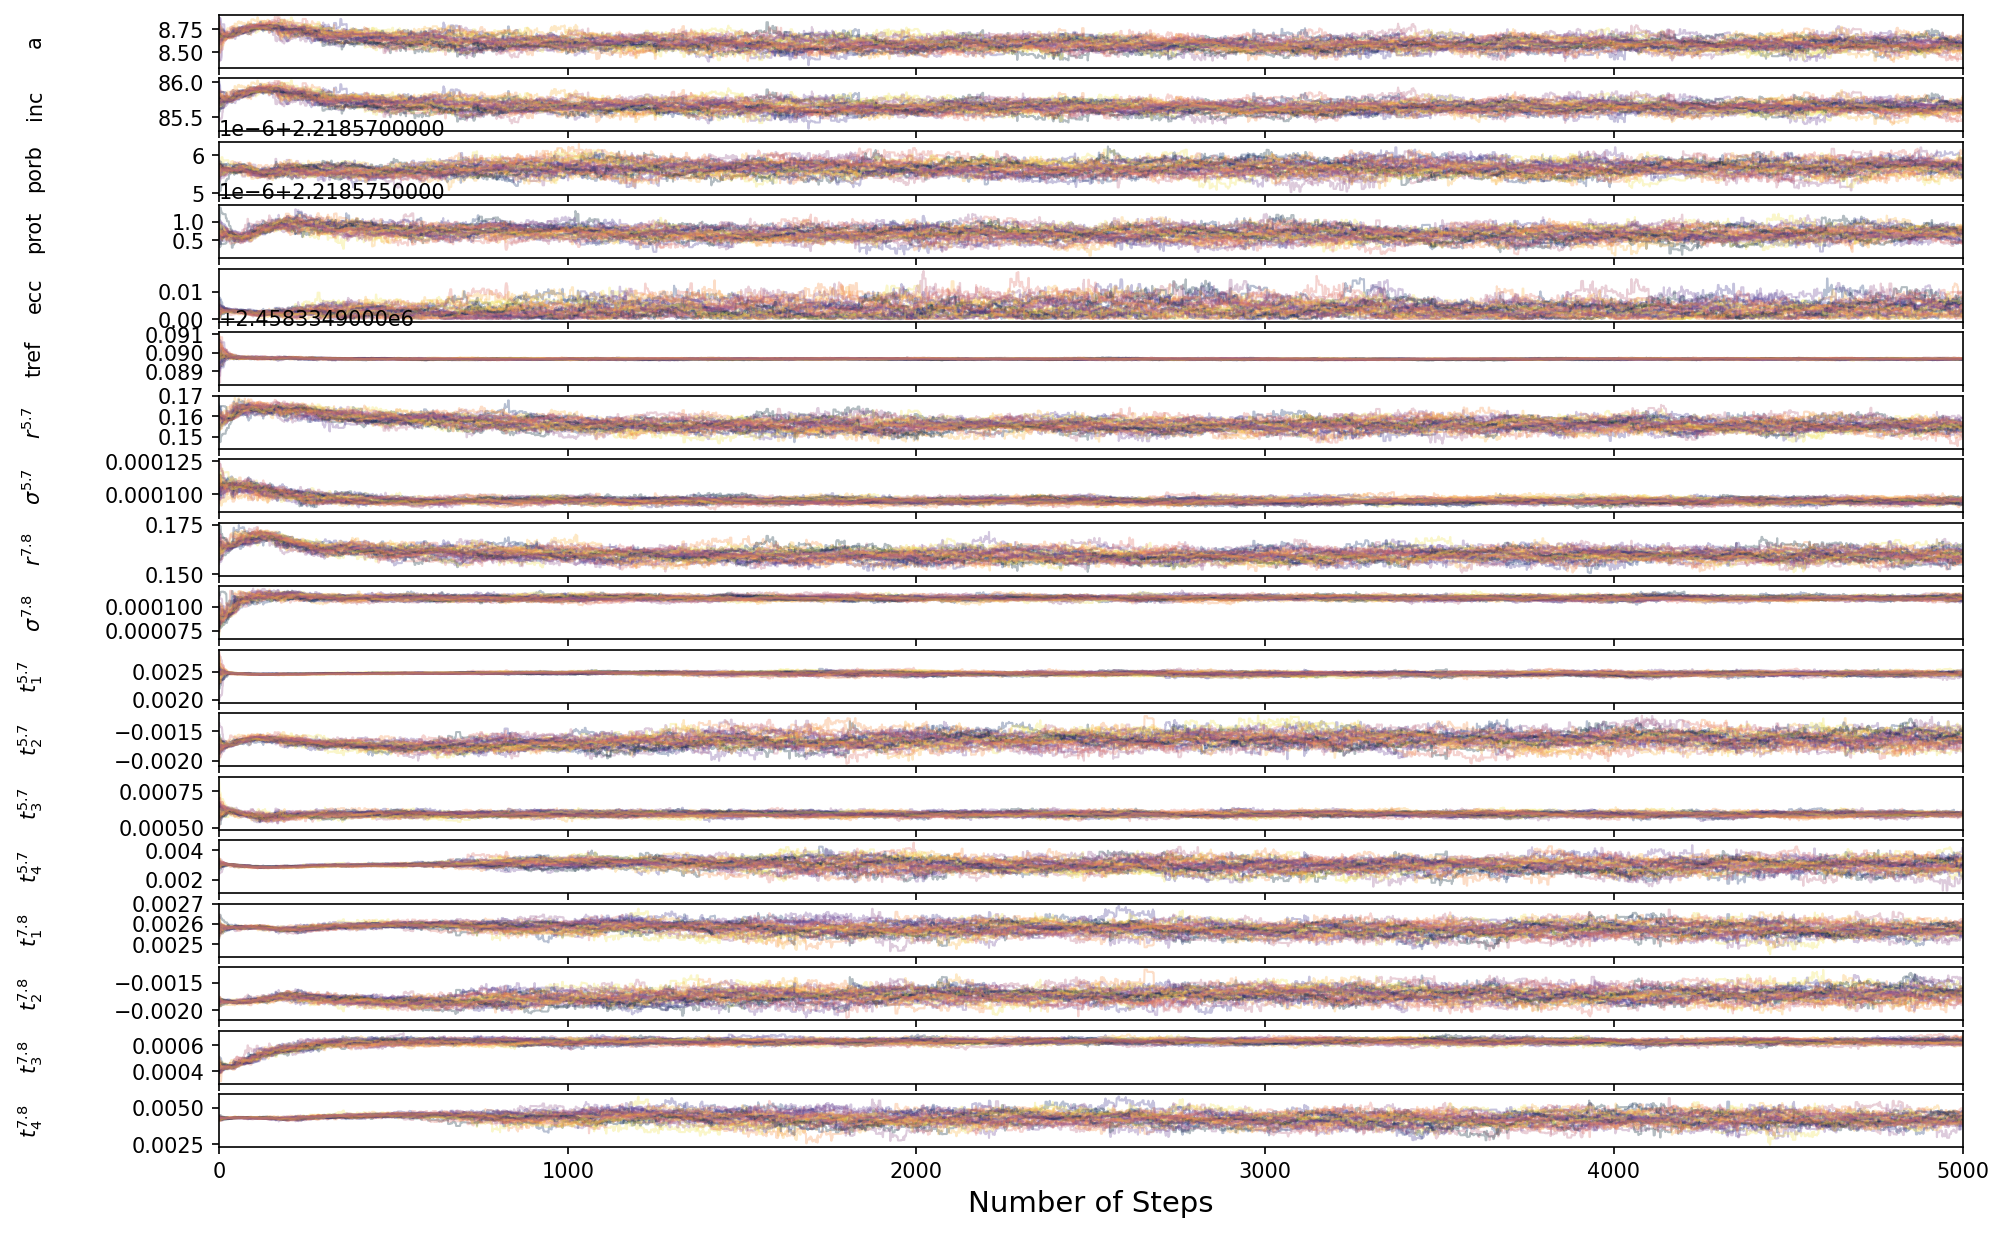

<Figure size 900x600 with 0 Axes>

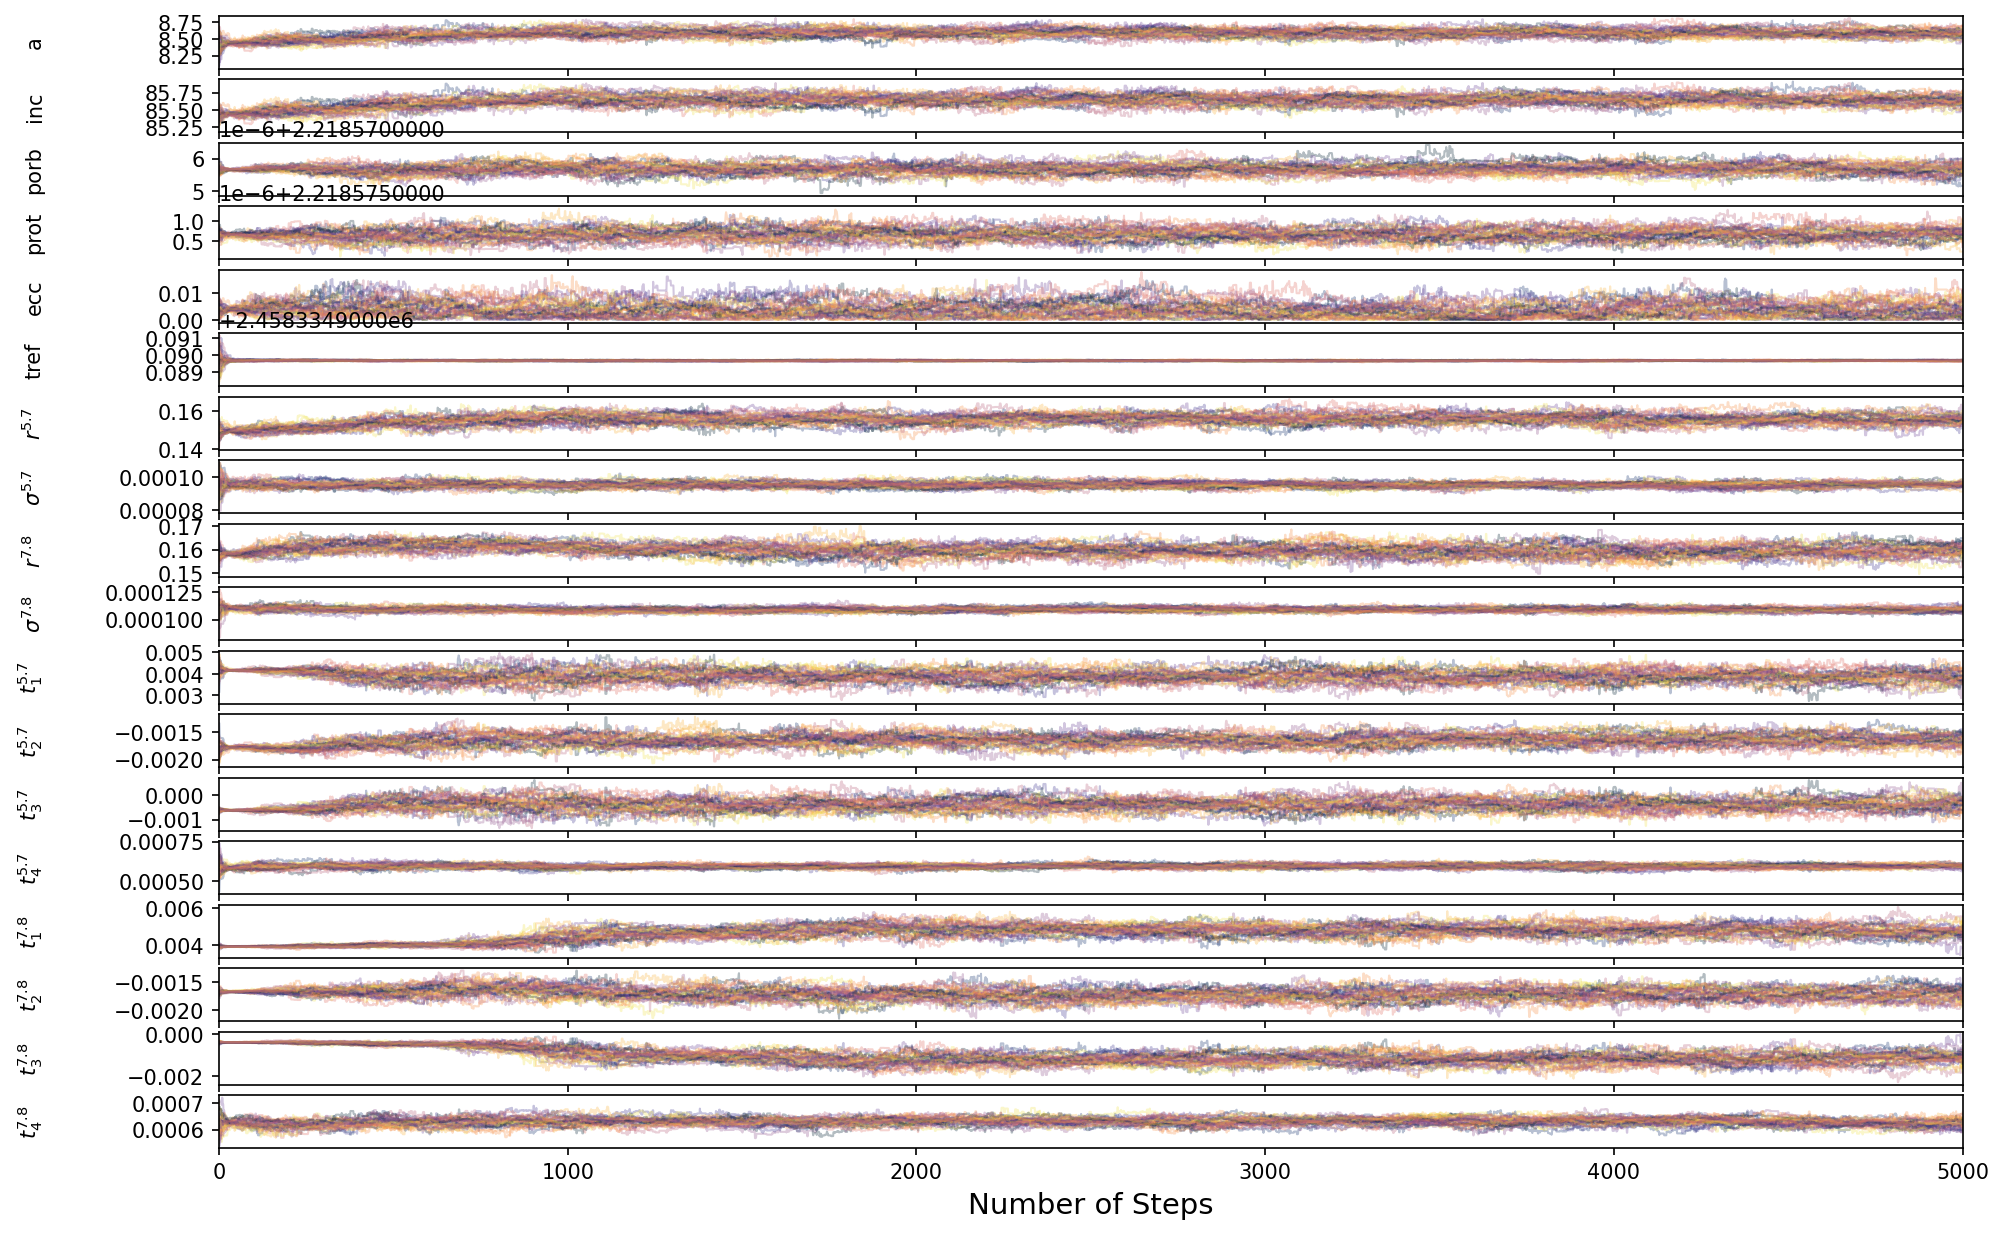

<Figure size 900x600 with 0 Axes>

<Figure size 2250x1500 with 0 Axes>

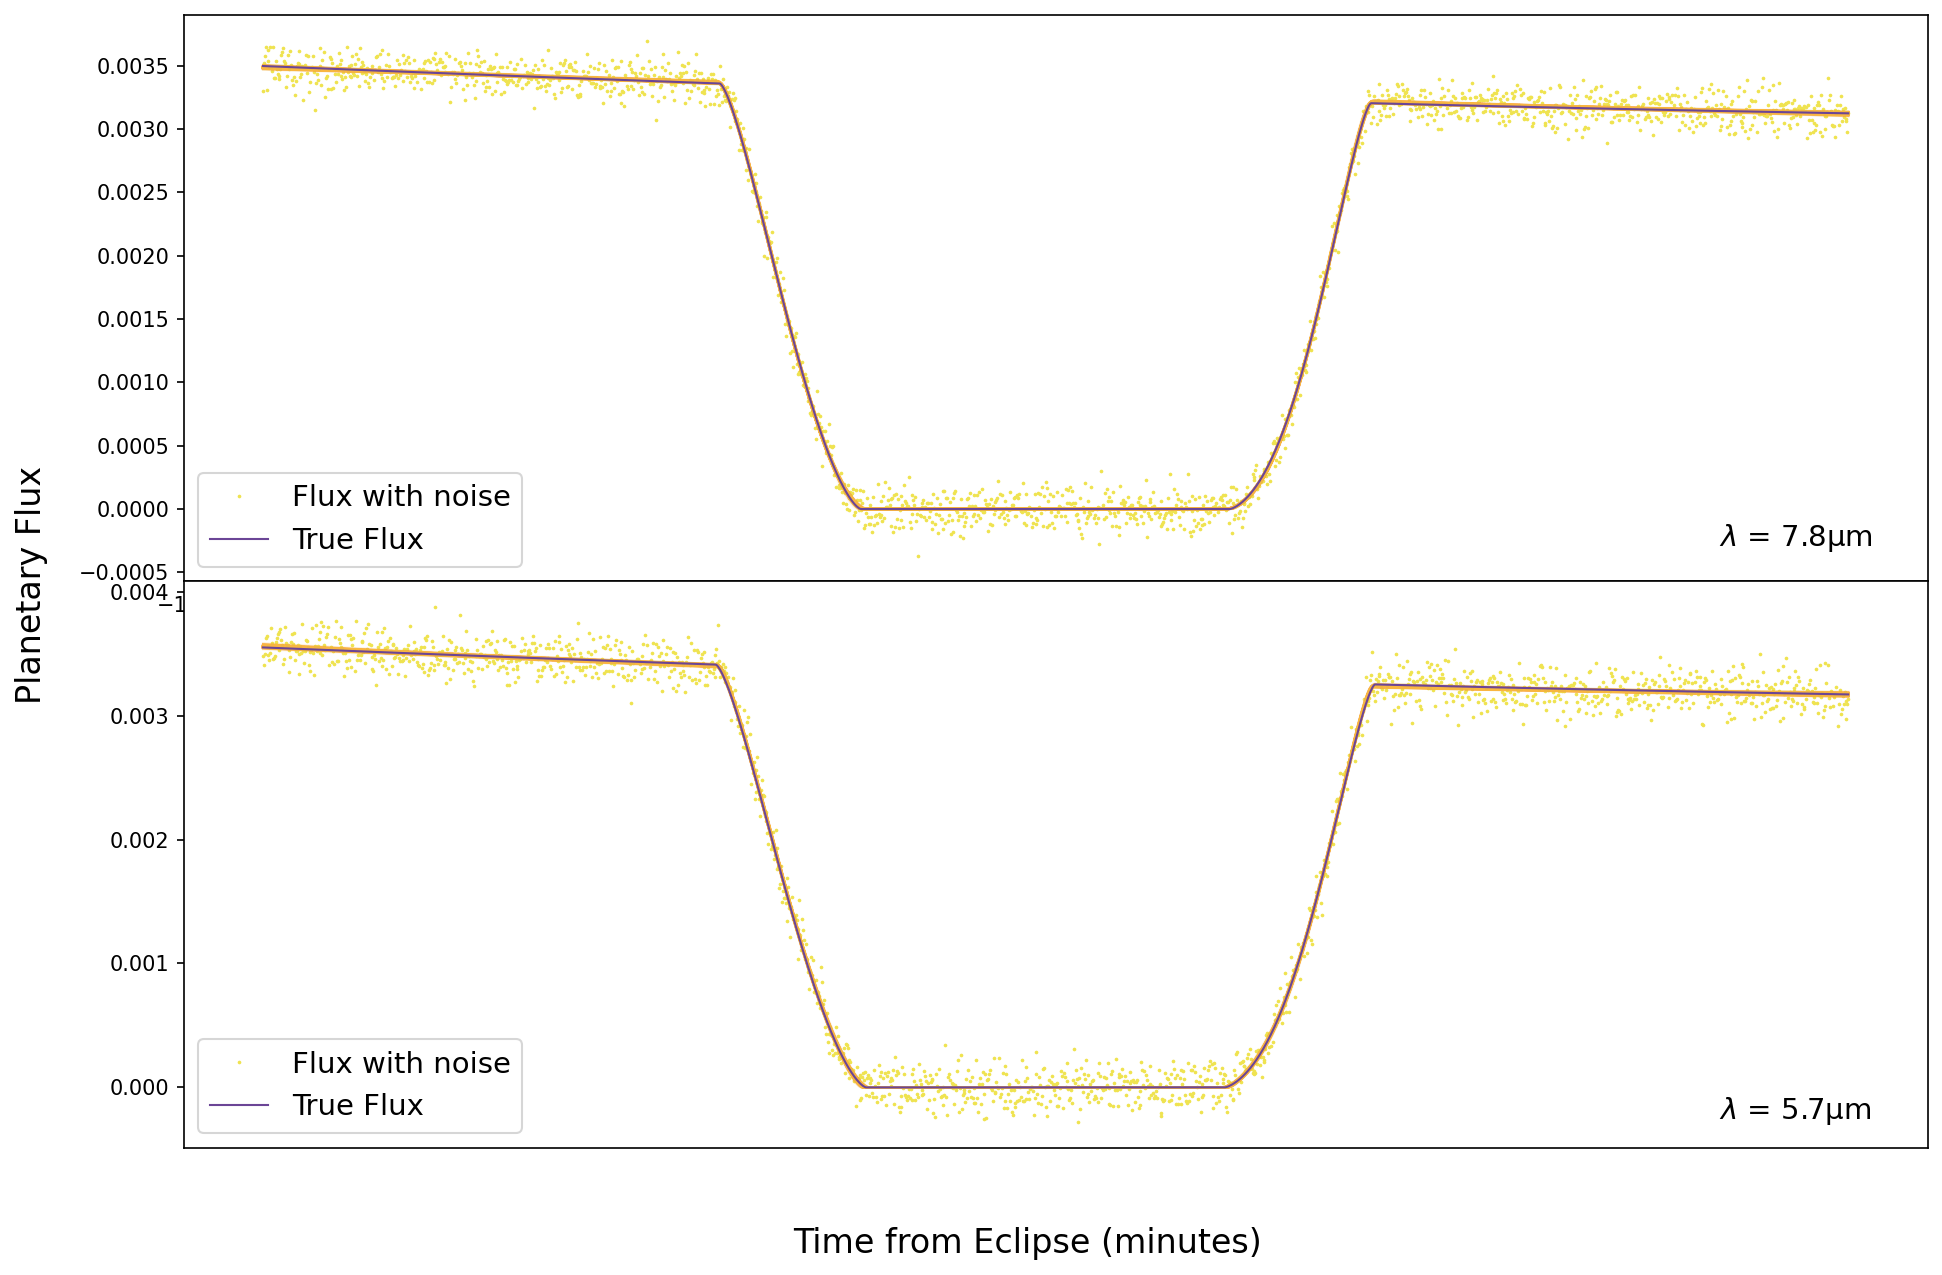

<Figure size 900x600 with 0 Axes>

<Figure size 2250x1500 with 0 Axes>

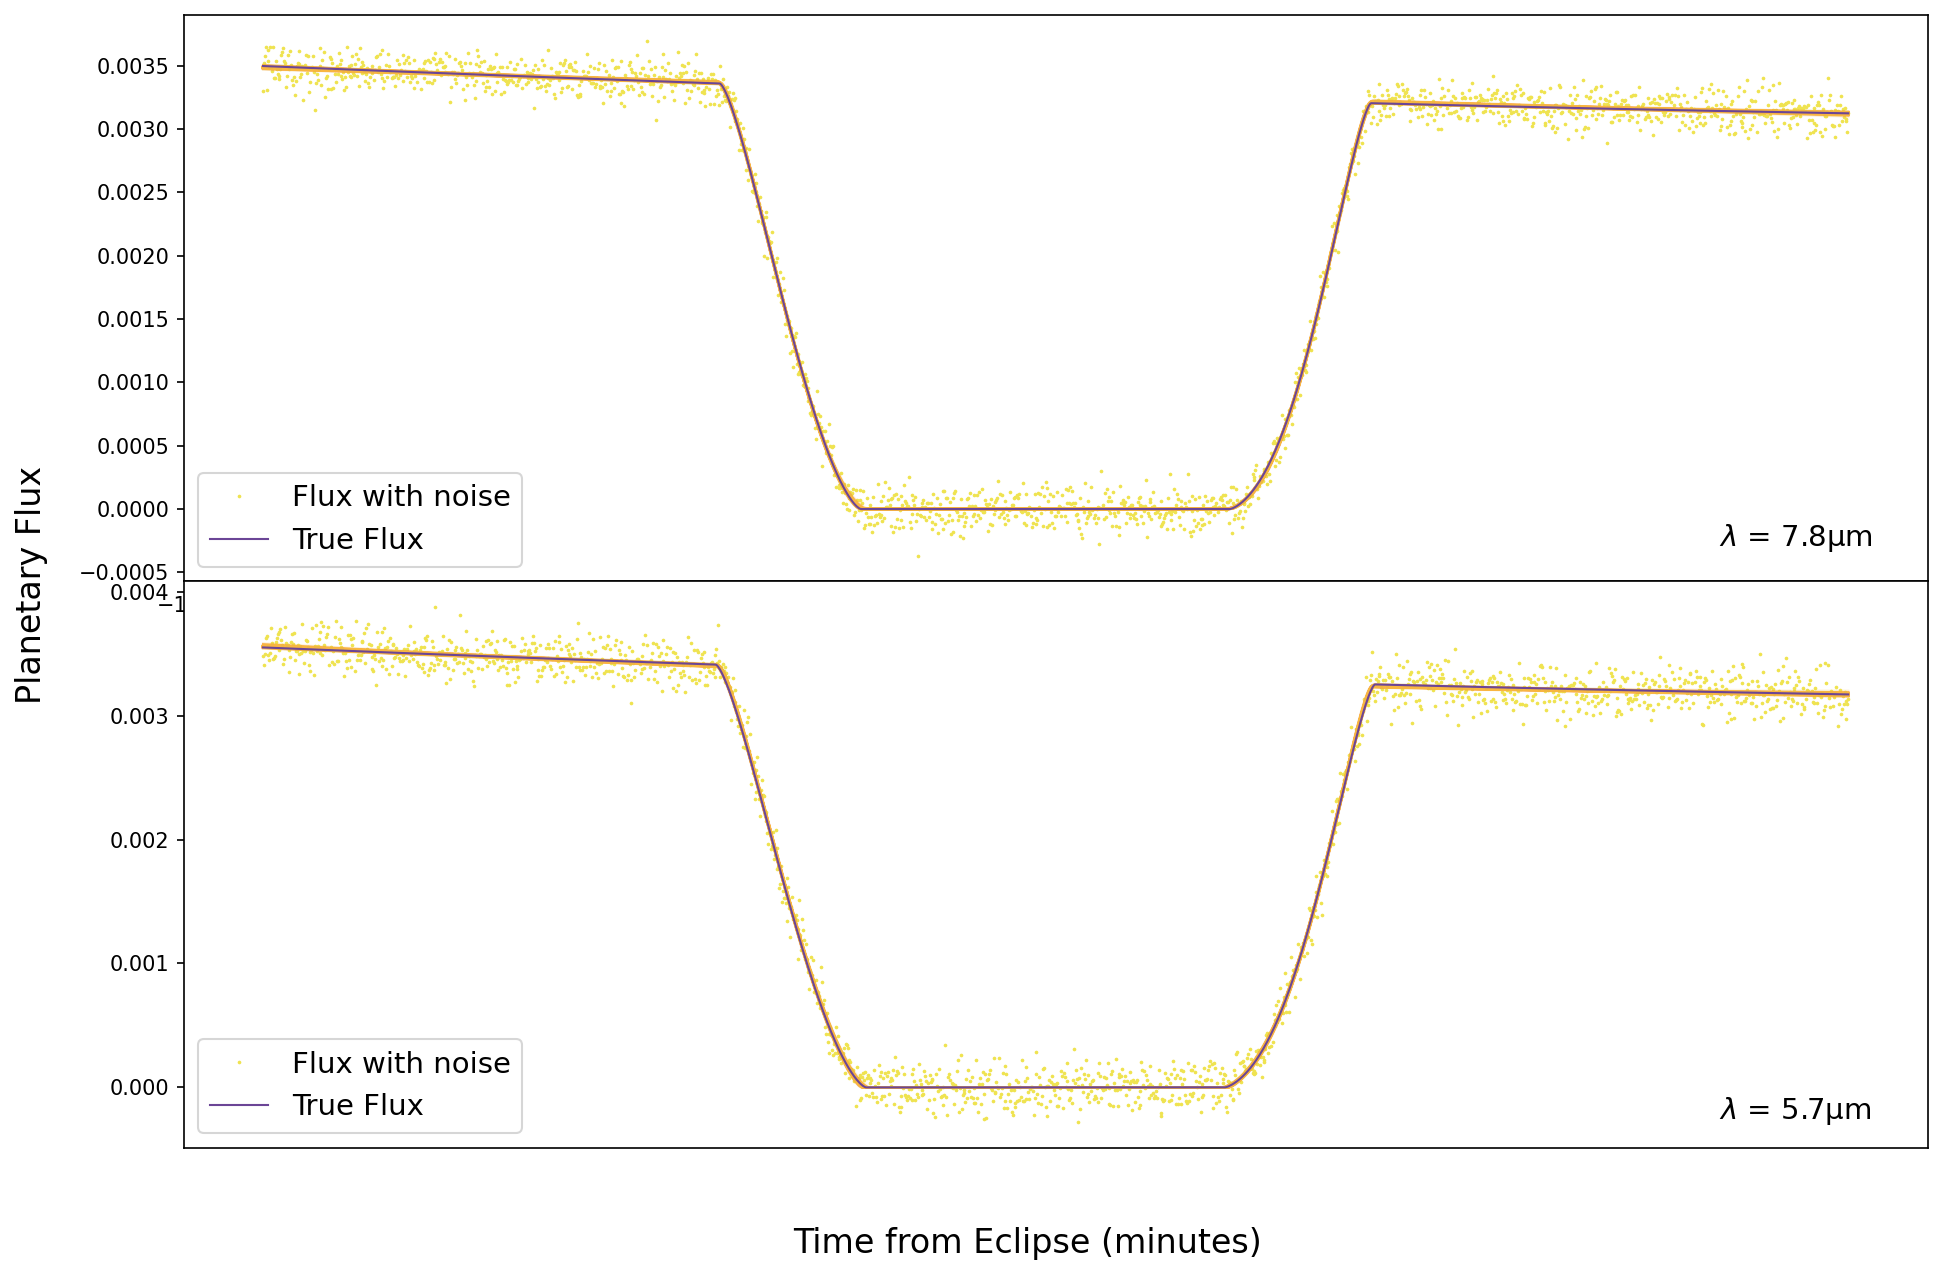

<Figure size 900x600 with 0 Axes>

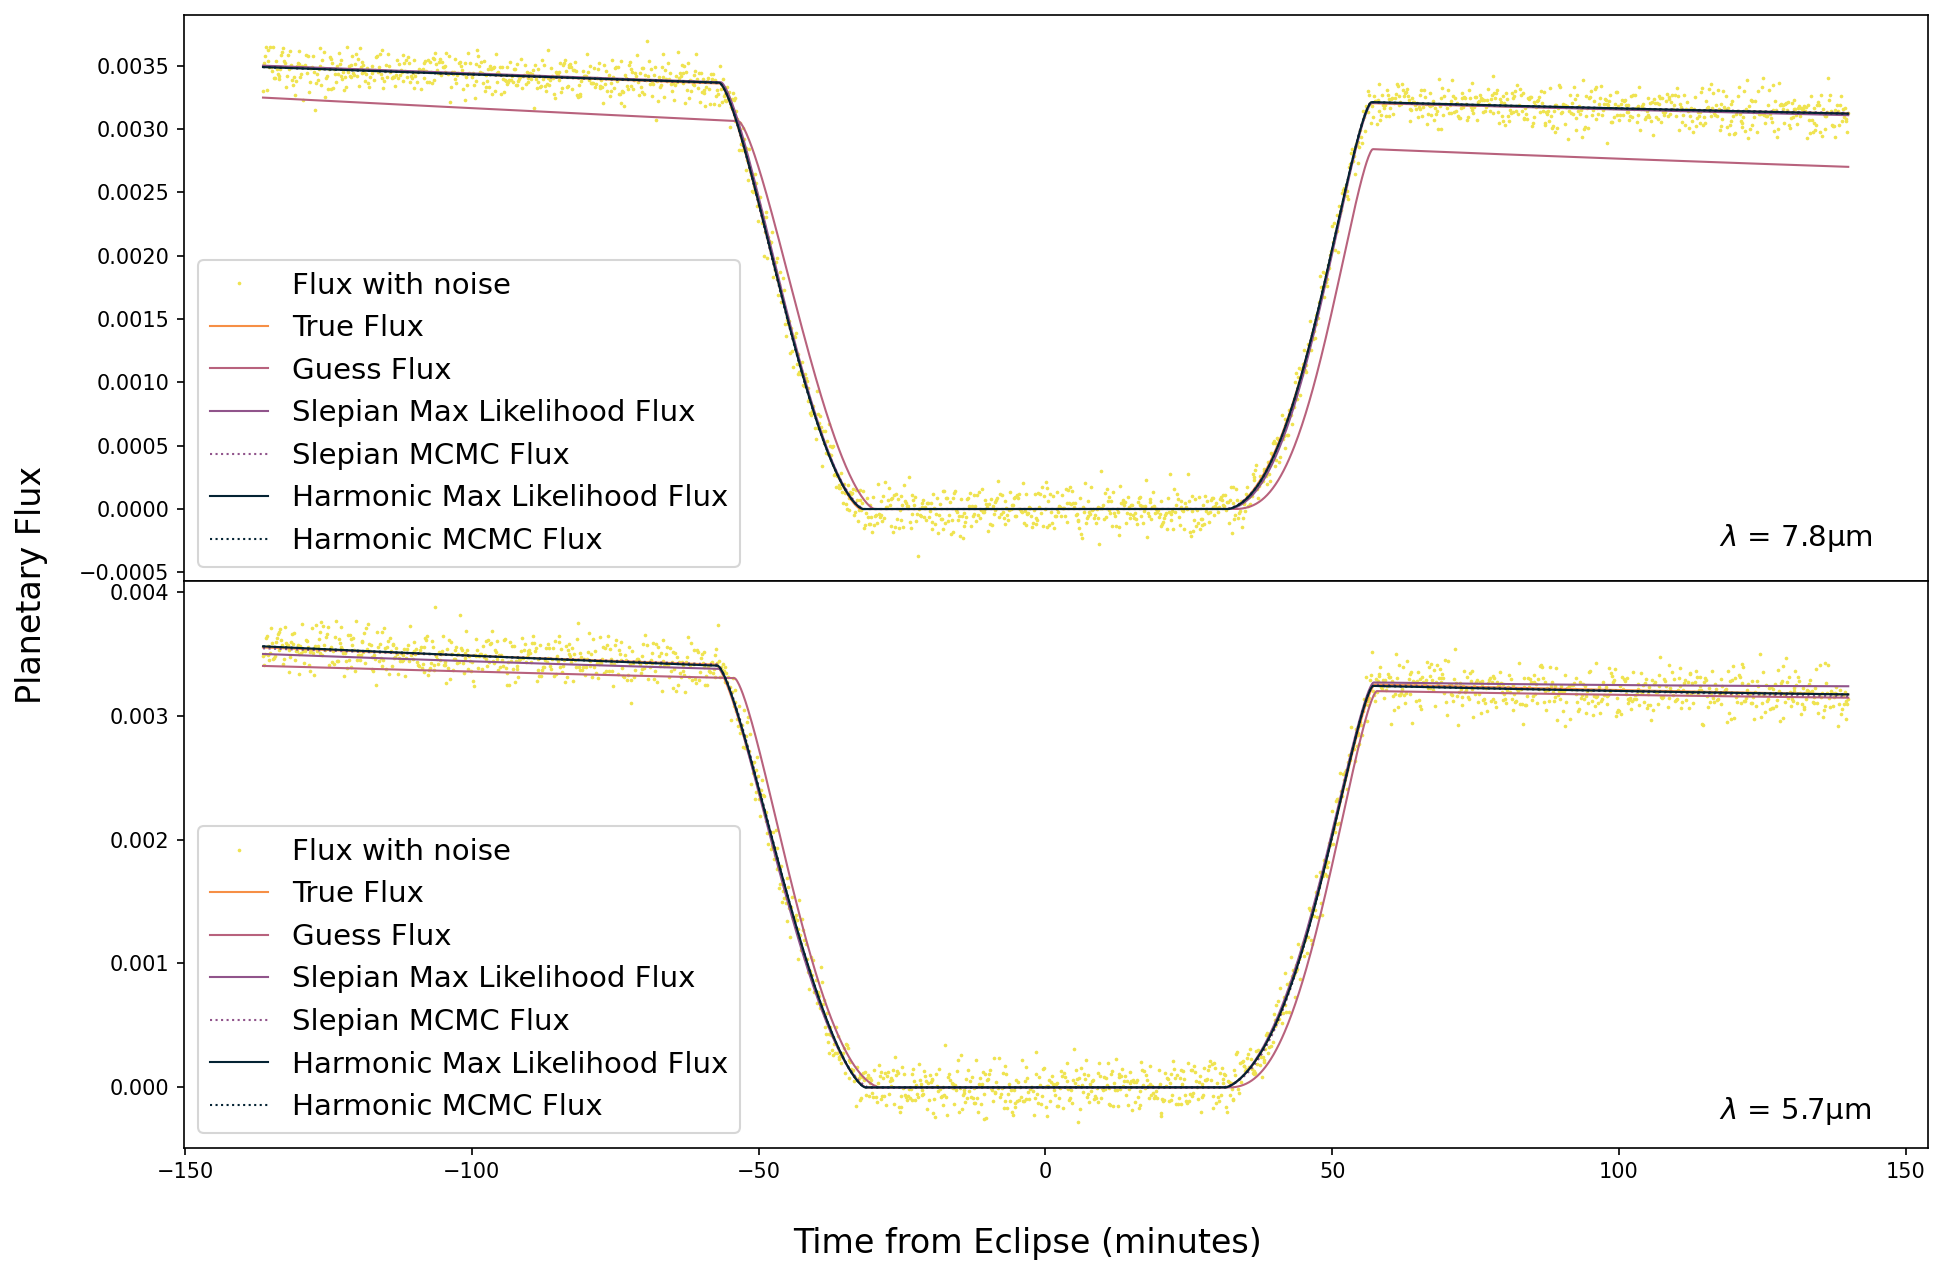

In [18]:
C = change_of_basis(1)

Flux, Sol = comparison_test(0, C, wav=[5.7, 7.8])